<a href="https://colab.research.google.com/github/vquinteop/TareasMineriadeDatosSemana1/blob/main/Cuaderno_4_ej_mainfifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo completo para un problema de regresión usando sci-kitlearn

Cuaderno modificado por: **Valentina Quintero Pamplona**

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/karangadiya/fifa19).

In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2021-11-14 19:40:25--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 74.125.203.101, 74.125.203.100, 74.125.203.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/brq4hsa76a784of73ole9g7g0qv9jr2b/elg5a29o0e3qbfoao4rf4lobj8vle602/1636918800000/09173029842254050324/13678542899671590554Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download [following]
--2021-11-14 19:40:27--  https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/brq4hsa76a784of73ole9g7g0qv9jr2b/elg5a29o0e3qbfoao4rf4lobj8vle602/1636918800000/09173029842254050324/13678542899671590554Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download
Resolving doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to 

# Lectura de la base de datos con Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,7/1/2004,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,7/10/2018,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,8/3/2017,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,7/1/2011,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,8/30/2015,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

## Tips básicos para escoger la estrategia de validación:

- Para $N\geq 5000$ se sugiere realizar entrenamiento hold-out, generando grupos de entrenamiento, validación y evaluación. Los conjuntos de entrenamiento y validación se pueden utilizar para realizar validación cruzada de 10 o 5 folds para determinar el mejor modelo y sus hiperparámetros. No obstante, si la cantidad de datos es muy grande, generalmente se utiliza un único conjunto de entrenamiento y un único conjunto de validación, e.g., modelos de deep learning generalmente utilizan esta estrategia por la gran cantidad de datos disponible.

**HoldOut con única partición de entrenamiento, validación y evaluación (training, validation, testing)**

![HoldOut](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/HoldOut.png?raw=1)


**HoldOut utilizando validación cruzada para definir varios conjuntos de entrenamiento y validación en la búsqueda del mejor modelo con evaluación final en un único conjunto de testing**

![grid_search_cross_validation](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/grid_search_cross_validation.png?raw=1)

- Se sugiere para $ 30 <N <5000$ realizar validación cruzada o validación cruzada anidad k folds (generalmente se trabaja con k=10 o k = 5), y reportar el desempeño promedio en el conjunto de test a lo largo de las rotaciones. En algunos textos, dado que se los datos se rotan y aparecen al menos una vez en el conjunto de training y una vez en el de testing, se habla solamente de conjuntos de entrenamiento y validación, porque el concepto de datos afuera (testing) se pierde.

![kfolds](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/kfolds.png?raw=1)

- La validación cruzada anidad es mucho más estricta a la hora de dejar un conjunto de test que no se utiliza para sintonizar los hiperparámetros (a diferencia del kfolds convencional que determina los mejores valores de hiperparametros respecto al conjunto de validación=evaluación). Sin embargo, la extensión anidad es más costosa computacionalmente.


![nestedcv](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/nestedcv.png?raw=1)

- Para $N \leq 30$ se sugiere trabajar con validación cruzada fijando el número de particiones igual al número de datos ($k=N$). En este caso, se tiene un conjunto de entrenamiento de $N-1$ y una única muestra de test que se rota $N$ veces (leave-one-out).



**Nota**: En este caso se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros. 

Se define el atributo Release Clause como salida.

In [4]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida - transformo en fit
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test - transformo en test

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [6]:
#print(ytrain[0],Xtrain.loc[0,"LS"])

In [7]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc 

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc   

In [8]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [9]:
ytrain_num[:5]

array([ 1100000.,   111000.,   224000.,   429000., 14400000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [10]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [11]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

In [12]:
cat_usr["Body Type"]

['Normal',
 'Lean',
 'Stocky',
 'Messi',
 'Shaqiri',
 'Akinfenwa',
 'PLAYER_BODY_TYPE_25',
 'C. Ronaldo',
 'Courtois',
 'Neymar']

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [13]:
#%% transformer custom
from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador
        
        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))
        
        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .       
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades 
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante
        
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado
        
        return self    

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])
        
                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
            
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi
    
    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [14]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [15]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [16]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12744 entries, 3786 to 13432
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  float64
 10  Weak Foot                 12744 non-null  float64
 11  Skill Moves               12744 non-null  float64
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Rea

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [17]:
corr_matrix = Xtrain_pre.corr()# matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

# Ejercicio 1:

a. Qué puede discutir sobre las correlaciones cálculadas?

b. Cuáles son los atributos que presentan una relación lineal más fuerte con la variable de salida?

## Solución 

a. De las correlaciones calculadas podemos decir que:
- Existe una alta correlación de la variable Overall con las variables Potential y Value. 
-  La variable Value se encuentra altamente correlacionada con las variables Wage, Potential y International Reputation.
- Se observa que la variables LS - ST - RS tienen una correlación igual a uno, por lo que se puede reducir a una sola variable pues estan explicando lo mismo. Esta situación no es unica de estas variables, pues LCM	- CM - RCM, poseen correlaciones igual a uno.
- Las variables GKDiving	GKHandling	GKKicking	GKPositioning	y GKReflexes, se encuentran altamente correlacionadas.

In [18]:
# Solución al punto b
# Para encontrar la correlación existente entre la ariable salida y las demas variables, se debe unir nuevmente a la base de datos y hallar la matriz de corelaciones
y_num = pd.DataFrame(ytrain_num, columns = ['Release clause'])
completa_train = pd.concat([Xtrain_pre.reset_index(drop=True), y_num],axis=1)
completa_train.head(5)
corr_matrix = completa_train.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

Ahora vemos que la variable salida (Release clause) se encuentra altamente correlacionada con las variables Value, Wage , Overall	y Potential.

# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

In [19]:
# Para darle solución al primer punto, 
# veamos primero los atributos que tenemos disponibles en la base de datos
Xtrain_pre.columns 

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [20]:
Xm =pd.DataFrame(Xtrain_pre[['Age','Overall','Potential']],columns=['Age','Overall','Potential'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida

In [21]:
Xm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12744 entries, 3786 to 13432
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        12744 non-null  int64  
 1   Overall    12744 non-null  int64  
 2   Potential  12744 non-null  int64  
 3   Output     12744 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.1 MB


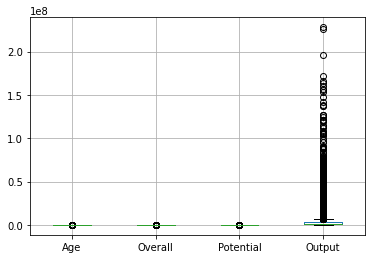

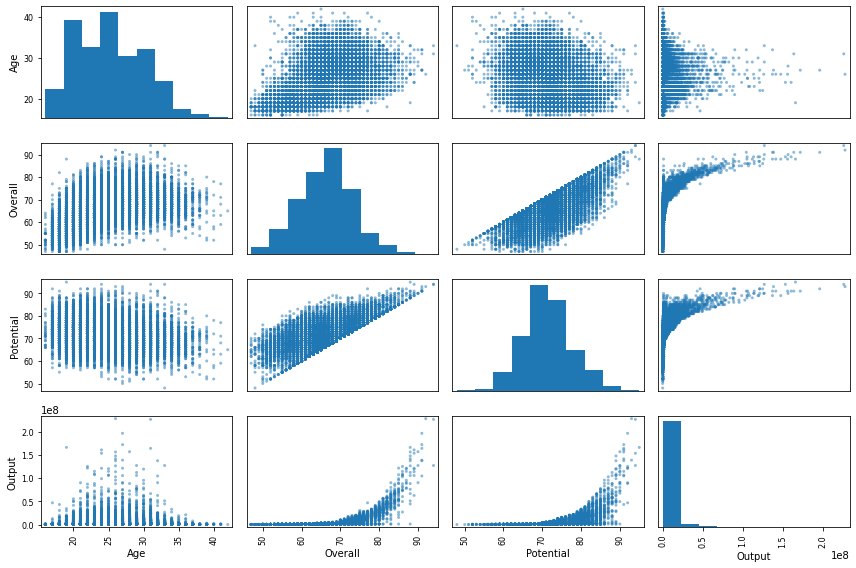

In [22]:
from pandas.plotting import scatter_matrix

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

In [23]:
# Se importa preprocesing para usar StandarScaler y MinMaxScaler

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# StandarScaler
scaler = StandardScaler().fit_transform(Xm)
print(type(scaler))
X_Standar_Scaler = pd.DataFrame(scaler)
# MinMaxScaler
min_max_scaler =preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(Xm)
X_train_minmax = pd.DataFrame(X_train_minmax)
type(X_train_minmax)

<class 'numpy.ndarray'>


pandas.core.frame.DataFrame

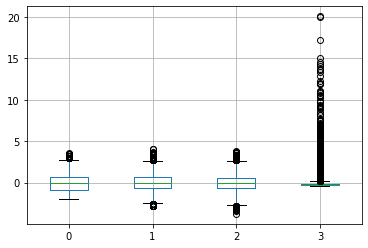

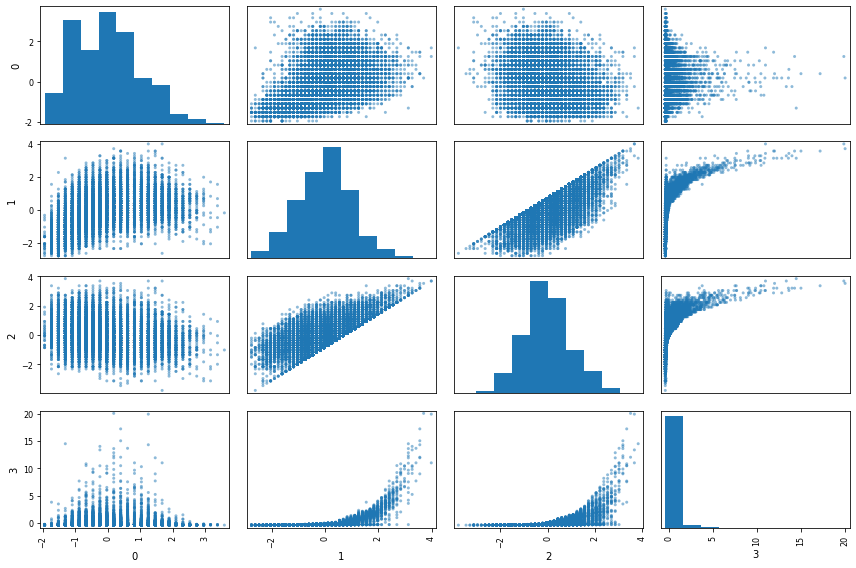

In [24]:
X_Standar_Scaler.boxplot()#grafica de caja
plt.show()
scatter_matrix(X_Standar_Scaler, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

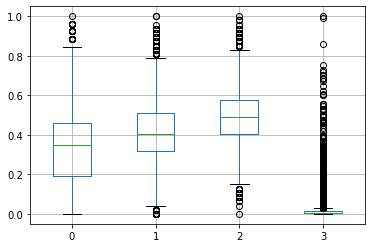

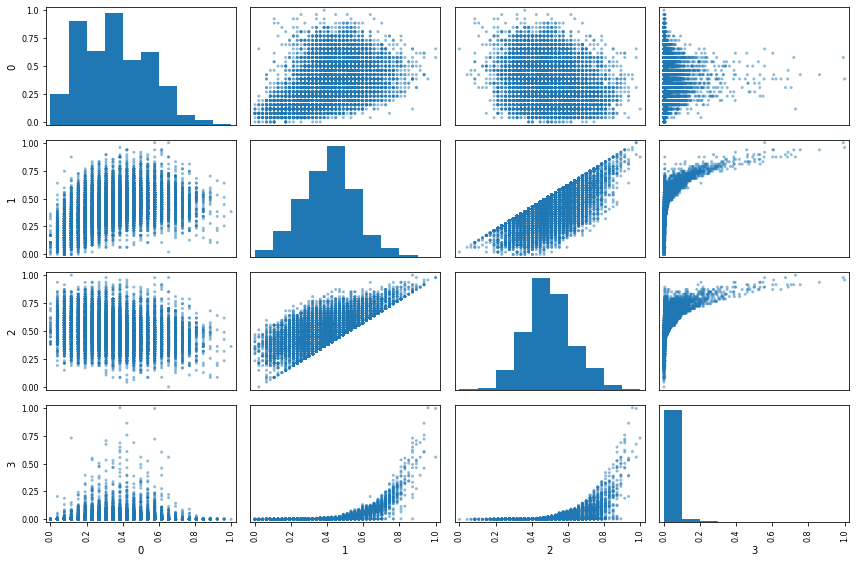

In [25]:
X_train_minmax.boxplot()#grafica de caja
plt.show()
scatter_matrix(X_train_minmax, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)), 
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(memory=None,
         steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Messi', 'Shaqiri',
                                                   'Akinfenwa',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'C. Ronaldo', 'Courtois',
                                                   'Neymar'],
                                     'Club': ['Frosinone', 'Rayo Vallecano',
                                              'Arsenal', 'Real Madrid',
                                              'Valencia CF', 'FC Barcelona',
                                              'Liverpool', 'Cardiff City',
                                              'Atlético Madrid', 'Empoli',
                                              'Everton', 'Tottenham Hotspur'...
                            col_euro=['Value', 'Wage'],
        

In [27]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

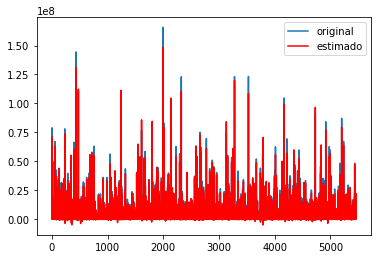

In [28]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

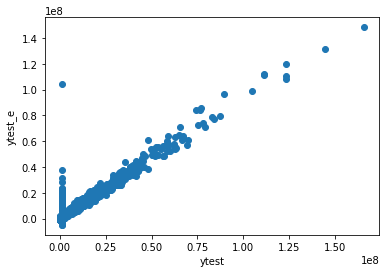

In [29]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



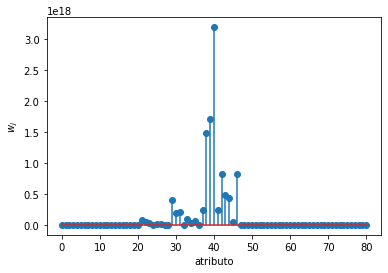

In [30]:
# Solución punto 1
plt.stem(abs(metodo_full.steps[2][1].coef_))
plt.xlabel('atributo')
plt.ylabel('$w_j$')
plt.show()

Se puede apreciar que los pesos de dichas vaariables poseen un valor significativo entre los atributos 20 y casi 50.

# Solución 2.

A continuación, se presentan algunos métodos que se espera que el valor objetivo sea una combinación lineal de las caracteristicas, basandose en el siguiente modelo:

$$y = f(x) = w_0 + w_1 x_1 + \dots + w_p x_p$$

- **LinearRegresor**: matemáticamente el problema a optimizar es:

$$ \min\limits_w  \left\|{Xw-y}\right\|_{2}^{2}$$

- **Lasso:** matemáticamente, es un modelo lineal que contiene un termino de regularización. La función objetivo a minimizar es:

$$\min\limits_w\frac{1}{2n_{muestras}}\left\|{Xw-y}\right\|_{2}^{2}+\alpha\left\|{w}\right\|_{1}$$

Donde $\left\|{w}\right\|_{1}$ es la norma $\mathscr{l}_1$ del vestor de los pesos.

- **Elastic-Net**: es un modelo de regresión lineal entrenado con ambas normas $\mathbb{l}_1$ y $\mathbb{l}_2$. La función objetivo a minimizar en este caso es:

$$\min\limits_w\frac{1}{2n_{muestras}}\left\|{Xw-y}\right\|_{2}^{2} + \alpha\rho\left\|{w}\right\|_{1} + \frac{\alpha(1-\rho)}{2}\left\|{w}\right\|_{2}^{2}$$

Es necesario ajustar los parametros $\alpha$ y $\rho$


In [40]:
# Solución Punto 3
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) 

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error as msa 

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg', LinearRegression())],
         
        #  [('scaler',StandardScaler()),
        #  ('reg',Ridge())],

        #  [('scaler',StandardScaler()),
        #  ('reg',Lasso())],
         
         #('scaler',StandardScaler()),
         # ('reg',ElasticNet())
         
          # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          # ('reg',  KernelRidge(kernel = 'rbf'))] #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
            #  {'reg__fit_intercept':[True, False]             
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Ridge
            #   'reg__fit_intercept':[True, False] 
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Lasso
            #   'reg__fit_intercept':[True, False] 
            #  },
             {
              'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros ElasticNet
              'reg__l1_ratio':[0,0.25,0.5,0.75,1]
             }
            #  {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
            #  'reg__alpha':[1e-3,1e-2,1e-1,1,10]
            #  }
              ]

pipeline = Pipeline(steps = steps)

scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 

grid_search.fit(Xtrain_pre, ytrain_num) # Validacion crusada 

ypred = grid_search.predict(Xtest_pre) # Prediccion mejores Hiper parametros

list_hyper=grid_search.best_params_ #guardar mejores parametros
msev=msa(ytest_num,ypred) # guardar mean_absolute_error

print(list_hyper, msev)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  4.0min finished


{'reg__alpha': 0.01, 'reg__l1_ratio': 0} 823369.7549487506


In [ ]:
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) 

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error as msa 

steps = [
        #  [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
        #   ('reg', LinearRegression())],
         
        #  [('scaler',StandardScaler()),
        #  ('reg',Ridge())],

        #  [('scaler',StandardScaler()),
        #  ('reg',Lasso())],
         
        # ('scaler',StandardScaler()),
         # ('reg',ElasticNet())
         
          # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          # ('reg',  KernelRidge(kernel = 'rbf'))] #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
            #  {'reg__fit_intercept':[True, False]             
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Ridge
            #   'reg__fit_intercept':[True, False] 
            #  },
            #  {'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros Lasso
            #   'reg__fit_intercept':[True, False] 
            #  },
             #{
              #'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros ElasticNet
              #'reg__l1_ratio':[0,0.25,0.5,0.75,1]
             #}
            #  {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
            #  'reg__alpha':[1e-3,1e-2,1e-1,1,10]
            #  }
              ]

pipeline = Pipeline(steps = steps)

scoring = {'absolute':'neg_mean_absolute_error','squares':'neg_mean_squared_error'}# diccionario metricas error https://scikit-learn.org/stable/modules/model_evaluation.html

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, cv=5, scoring=scoring, verbose=10, refit='absolute')# refit se escoje la metrica con la que desea optimizar 

grid_search.fit(Xtrain_pre, ytrain_num) # Validacion crusada 

ypred = grid_search.predict(Xtest_pre) # Prediccion mejores Hiper parametros

list_hyper=grid_search.best_params_ #guardar mejores parametros
msev=msa(ytest_num,ypred) # guardar mean_absolute_error

print(list_hyper, msev)

In [32]:
metodo_full.steps

[('preproceso',
  mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky', 'Messi',
                                    'Shaqiri', 'Akinfenwa', 'PLAYER_BODY_TYPE_25',
                                    'C. Ronaldo', 'Courtois', 'Neymar'],
                      'Club': ['Frosinone', 'Rayo Vallecano', 'Arsenal',
                               'Real Madrid', 'Valencia CF', 'FC Barcelona',
                               'Liverpool', 'Cardiff City', 'Atlético Madrid',
                               'Empoli', 'Everton', 'Tottenham Hotspur',
                               'Manchester United', 'Eintracht Frankfurt',
                               '...
                      'Preferred Foot': ['Right', 'Left'],
                      'Real Face': ['No', 'Yes'],
                      'Work Rate': ['Medium/ Medium', 'High/ Medium',
                                    'Medium/ High', 'High/ High', 'Medium/ Low',
                                    'High/ Low', 'Low/ Medium', 'Low/ High',
     

In [33]:
metodo_full.steps[2]

('regresion',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [34]:
metodo_full.steps[2][1]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
metodo_full.steps[2][1].coef_

array([ 2.79979752e+05,  5.37464583e+04, -5.98616517e+05,  2.00495865e+05,
       -1.35915721e+05,  1.15064946e+07, -2.67719578e+05, -2.66536874e+05,
       -1.31444873e+04, -3.13632918e+05, -5.11836981e+03, -8.68509494e+04,
        8.19051953e+04,  2.86393320e+04,  7.54635162e+04, -8.99870487e+04,
       -3.91631364e+03,  1.33892313e+05, -3.69655347e+05, -5.27945890e+03,
       -5.02823463e+04, -7.92566930e+16,  5.51591739e+16,  2.40975190e+16,
       -1.48475435e+15, -1.05605082e+16,  1.27534132e+16, -2.19290492e+15,
        1.48475435e+15,  4.00059466e+17, -1.95963736e+17, -2.04095730e+17,
       -2.43763210e+15, -9.22138129e+16,  3.58195083e+16,  5.63943046e+16,
        2.43763210e+15, -2.44100432e+17, -1.48508624e+18, -1.71168678e+18,
        3.19677302e+18,  2.44100432e+17, -8.27503173e+17, -4.81775236e+17,
        4.35604513e+17,  4.61707231e+16,  8.27503173e+17,  1.71968000e+05,
        3.72312000e+05,  1.12576000e+05,  3.73120000e+04, -2.11968000e+05,
       -1.11108000e+05,  

<StemContainer object of 3 artists>

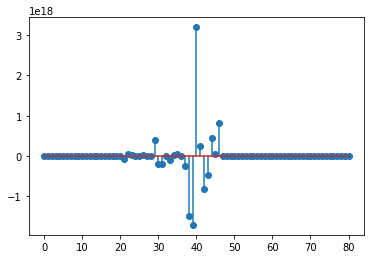

In [36]:
plt.stem(metodo_full.steps[2][1].coef_)

<StemContainer object of 3 artists>

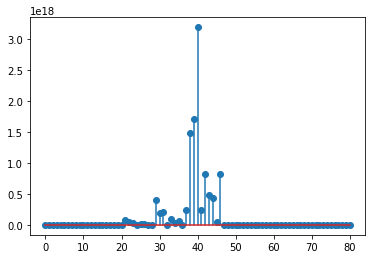

In [37]:
# nos importa la magnitud, dibujamos la cargas
plt.stem(abs(metodo_full.steps[2][1].coef_))

In [38]:
# El proceso es largo, modelos pesados, 